# ***SARIMA***

This notebook demonstrates the process of designing, training, and evaluating an SARIMA model using the hourly energy load data.
We aim to forecast future energy load based on historical data.

### Import Libraries

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle

### Data Loading

In [1]:


# Load the dataset
file_path = 'dataset.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()


,Datetime,PJM_Load_MW
0,1998-12-31 01:00:00,29309.0
1,1998-12-31 02:00:00,28236.0
2,1998-12-31 03:00:00,27692.0
3,1998-12-31 04:00:00,27596.0
4,1998-12-31 05:00:00,27888.0


### Pre Processing

In [2]:
# Convert 'Datetime' to datetime type and set as index
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('Datetime', inplace=True)

# Check for missing values
missing_values = data.isna().sum()
print(missing_values)

PJM_Load_MW    0
dtype: int64


### Stationary Test

In [3]:
# Perform Augmented Dickey-Fuller test to check stationarity
adf_result = adfuller(data['PJM_Load_MW'])

# Create a summary of the ADF test results
adf_summary = {
    'ADF Statistic': adf_result[0],
    'p-value': adf_result[1],
    'Critical Values': adf_result[4],
}

adf_summary

{'ADF Statistic': -14.496714853893716,
 'p-value': 6.024269615144993e-27,
 'Critical Values': {'1%': -3.4305491234409735,
  '5%': -2.8616280074583162,
  '10%': -2.566816843635725}}

### ACF and PCF

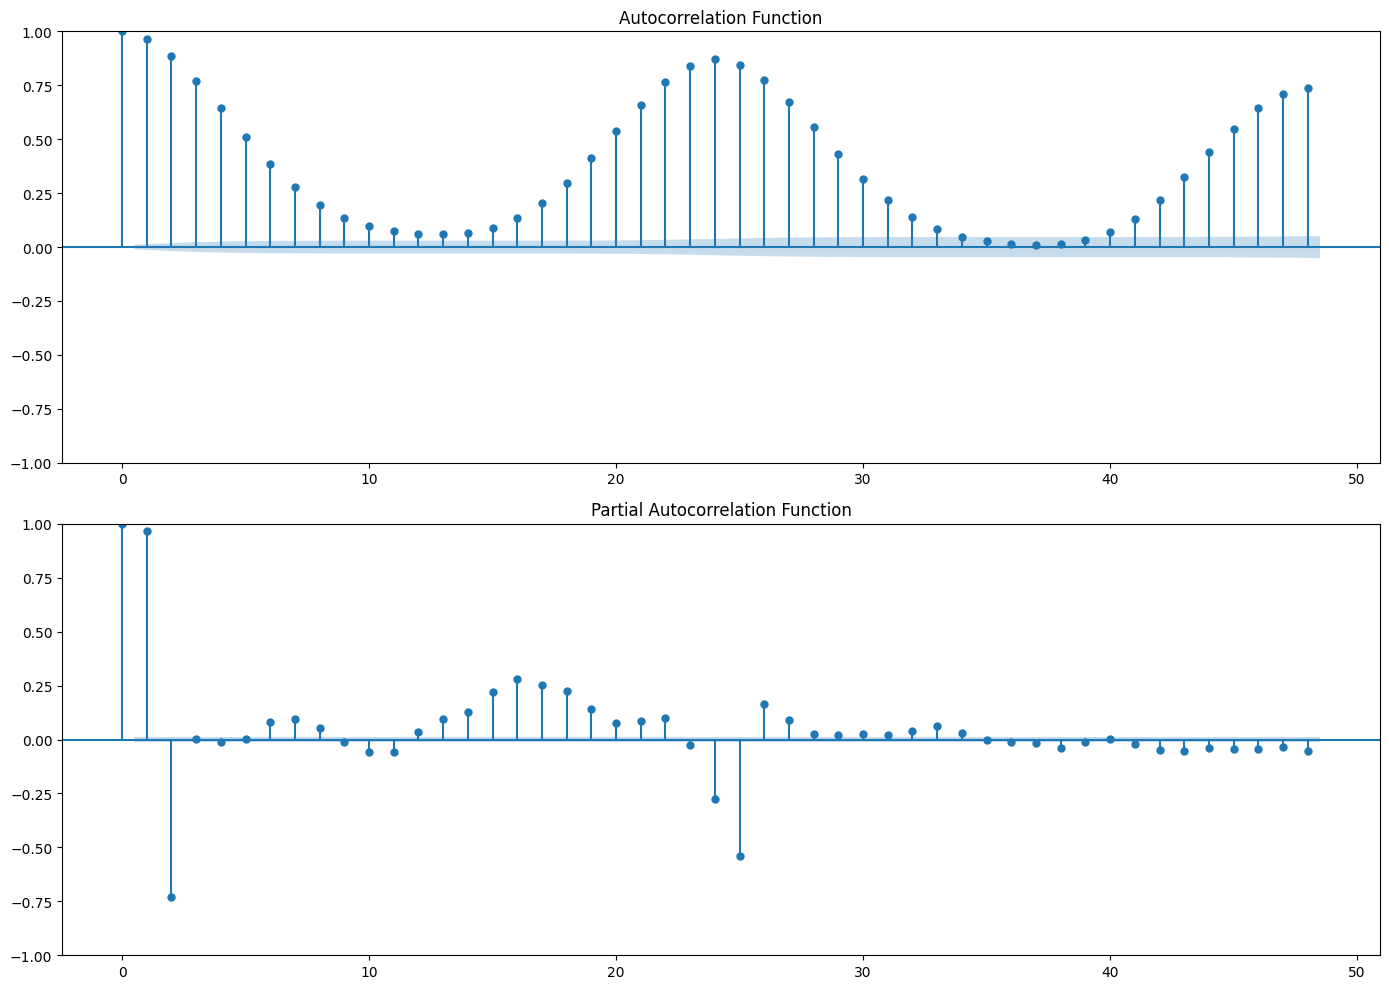

In [4]:
# Plotting ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Autocorrelation Function (ACF)
plot_acf(data['PJM_Load_MW'], ax=axes[0], lags=48, title='Autocorrelation Function')

# Partial Autocorrelation Function (PACF)
plot_pacf(data['PJM_Load_MW'], ax=axes[1], lags=48, title='Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

### Model Training

In [5]:


# Define SARIMA model parameters
order = (1, 0, 1)       # Non-seasonal parameters
seasonal_order = (1, 0, 1, 24)  # Seasonal parameters (with seasonality of 24 hours)

# Fit SARIMA model
model = SARIMAX(data['PJM_Load_MW'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
sarima_model = model.fit(disp=False)

# Display model summary
sarima_model.summary()


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        PJM_Load_MW   No. Observations:                32896
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood             -263893.071
Date:                            Sat, 11 May 2024   AIC                         527796.143
Time:                                    21:07:38   BIC                         527838.144
Sample:                                         0   HQIC                        527809.561
                                          - 32896                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9912      0.001   1311.750      0.000       0.990       0.993
ma.L1          0.3176      0.003    110.307      0.000       0.312       0.323
ar.S.L24       0.6990      0.003    278.928      0.000       0.694       0.704
ma.S.L24       0.3197      0.003    126.172      0.000       0.315       0.325
sigma2      5.507e+05   1735.135    317.371      0.000    5.47e+05    5.54e+05
===================================================================================
Ljung-Box (L1) (Q):                  90.52   Jarque-Bera (JB):            706257.51
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [6]:
# Generate forecasts for the next 12 hours
forecast = sarima_model.get_forecast(steps=12)

# Get the forecast mean and the confidence intervals
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Display the forecast
print(forecast_mean)
print(confidence_intervals)


32896    27138.485881
32897    26249.421015
32898    25337.687526
32899    24794.894791
32900    24648.747539
32901    24451.669138
32902    24312.927294
32903    23977.597584
32904    24359.582322
32905    25125.461790
32906    25720.369293
32907    25822.552430
Name: predicted_mean, dtype: float64
       lower PJM_Load_MW  upper PJM_Load_MW
32896       25684.038037       28592.933724
32897       23853.834766       28645.007264
32898       22288.329989       28387.045063
32899       21217.775704       28372.013877
32900       20619.910086       28677.584993
32901       20023.699861       28879.638414
32902       19525.132000       29100.722588
32903       18860.880967       29094.314200
32904       18939.125590       29780.039054
32905       19422.333145       30828.590434
32906       19752.559598       31688.178987
32907       19605.676157       32039.428703


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Evaluation Metrics

In [7]:


# Calculate the Mean Squared Error (MSE) and Mean Absolute Error (MAE)
mse = mean_squared_error(data['PJM_Load_MW'][-12:], forecast_mean)
mae = mean_absolute_error(data['PJM_Load_MW'][-12:], forecast_mean)
rmse = np.sqrt(mse)
accuaracy = 1 - (rmse / data['PJM_Load_MW'].mean())

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Accuracy: {accuaracy:.2%}')


Mean Squared Error (MSE): 59532667.45791235
Mean Absolute Error (MAE): 7172.96694992487
Root Mean Squared Error (RMSE): 7715.741536489694
Accuracy: 74.08%


### Saving Model

In [ ]:
# Assume 'sarima_model' is your trained SARIMA model
model_filename = 'SARIMA.pkl'  # specify the path and file name

# Save the model to disk
with open(model_filename, 'wb') as file:
    pickle.dump(sarima_model, file)

print("Model saved successfully at:", model_filename)


### Forecasting

In [8]:
# Specify the path where your model is saved
model_filename = 'SARIMA.pkl'  # replace with the actual path to your model file

# Load the model from disk
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Now you can use 'loaded_model' to make forecasts
# For example, to forecast the next 12 hours:
forecast = loaded_model.get_forecast(steps=12)
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Print the forecast results
print("Forecasted values:", forecast_mean)
print("Confidence intervals:", confidence_intervals)


Forecasted values: 32896    27138.485881
32897    26249.421015
32898    25337.687526
32899    24794.894791
32900    24648.747539
32901    24451.669138
32902    24312.927294
32903    23977.597584
32904    24359.582322
32905    25125.461790
32906    25720.369293
32907    25822.552430
Name: predicted_mean, dtype: float64
Confidence intervals:        lower PJM_Load_MW  upper PJM_Load_MW
32896       25684.038037       28592.933724
32897       23853.834766       28645.007264
32898       22288.329989       28387.045063
32899       21217.775704       28372.013877
32900       20619.910086       28677.584993
32901       20023.699861       28879.638414
32902       19525.132000       29100.722588
32903       18860.880967       29094.314200
32904       18939.125590       29780.039054
32905       19422.333145       30828.590434
32906       19752.559598       31688.178987
32907       19605.676157       32039.428703


c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
